In [1]:
# ============================================================
# 01: Data Exploration & Analysis — FloodNet
# ------------------------------------------------------------
# Objectives:
# - Inspect dataset structure
# - Analyze class distribution
# - Visualize sample images & masks
# - Compute class weights for training
# ============================================================

# -------------------------
# 1. Setup & Imports
# -------------------------
# Core, image, data and plotting utilities.
import os
import sys
import cv2                 # image I/O
import numpy as np        # numeric arrays
import pandas as pd       # tabular data
import matplotlib.pyplot as plt
import seaborn as sns     # nicer plots
from pathlib import Path  # filesystem paths
from collections import Counter
from tqdm import tqdm     # progress bars
import json
import warnings
warnings.filterwarnings('ignore')  # keep output clean

# -------------------------
# Plot style
# -------------------------
# Use a clean seaborn-based style and a pleasant palette.
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

# -------------------------
# Quick sanity prints
# -------------------------
# Confirm imports and versions (helpful for reproducibility).
print("✅ All libraries imported successfully!")
print(f"Python version: {sys.version.split()[0]}")
print(f"NumPy version: {np.__version__}")
print(f"OpenCV version: {cv2.__version__}")


✅ All libraries imported successfully!
Python version: 3.11.9
NumPy version: 1.26.4
OpenCV version: 4.8.0


In [ ]:
# ============================================================
# 2. Project Configuration
# ------------------------------------------------------------
# Centralized paths, dataset parameters and visualization
# metadata for the FloodNet data-exploration workflow.
# ============================================================

class Config:
    """Minimal project configuration (update BASE_DIR for your machine)."""
    # Root project directory — change this to your local path
    BASE_DIR = Path(r"D:\Projects\Image_Segmentation_for_Disaster_Resilience\Disaster-segmentation")

    # Raw data root (FloodNet)
    DATA_DIR = BASE_DIR / "data"
    RAW_DATA = DATA_DIR / "raw" / "FloodNet"

    # Dataset folders
    TRAIN_IMAGES = RAW_DATA / "train" / "train-org-img"
    TRAIN_MASKS  = RAW_DATA / "train" / "train-label-img"
    VAL_IMAGES   = RAW_DATA / "val" / "val-org-img"
    VAL_MASKS    = RAW_DATA / "val" / "val-label-img"
    TEST_IMAGES  = RAW_DATA / "test"  / "test-org-img"
    TEST_MASKS   = RAW_DATA / "test"  / "test-label-img"

    # Output folders (visualizations, CSVs, metrics, etc.)
    RESULTS_DIR = BASE_DIR / "results"
    VIZ_DIR     = RESULTS_DIR / "visualizations" / "data_exploration"
    METRICS_DIR = RESULTS_DIR / "metrics"

    # Image preprocessing / model input
    IMG_HEIGHT = 256   # target height
    IMG_WIDTH  = 256   # target width
    NUM_CLASSES = 10   # number of segmentation classes

    # Class metadata (index → name)
    CLASS_NAMES = [
        "Background",
        "Building-flooded",
        "Building-non-flooded",
        "Road-flooded",
        "Road-non-flooded",
        "Water",
        "Tree",
        "Vehicle",
        "Pool",
        "Grass"
    ]

    # Visualization colors (RGB, 0-255)
    CLASS_COLORS = {
        0: (0, 0, 0),           # Background
        1: (255, 0, 0),         # Building-flooded
        2: (0, 0, 255),         # Building-non-flooded
        3: (255, 165, 0),       # Road-flooded
        4: (128, 128, 128),     # Road-non-flooded
        5: (0, 255, 255),       # Water
        6: (0, 255, 0),         # Tree
        7: (255, 0, 255),       # Vehicle
        8: (255, 255, 255),     # Pool
        9: (0, 128, 0)          # Grass
    }


# Ensure output folders exist
Config.VIZ_DIR.mkdir(parents=True, exist_ok=True)
Config.METRICS_DIR.mkdir(parents=True, exist_ok=True)

# Print a concise configuration summary
print("=" * 60)
print("PROJECT CONFIGURATION")
print("=" * 60)
print(f"📂 Base Directory:      {Config.BASE_DIR}")
print(f"🖼️  Target Image Size:   {Config.IMG_HEIGHT}x{Config.IMG_WIDTH}")
print(f"🏷️  Number of Classes:   {Config.NUM_CLASSES}")
print(f"📊 Output Directory:     {Config.RESULTS_DIR}")
print("=" * 60)

PROJECT CONFIGURATION
📂 Base Directory:      D:\Projects\Image_Segmentation_for_Disaster_Resilience\Disaster-segmentation
🖼️  Target Image Size:   256x256
🏷️  Number of Classes:   10
📊 Output Directory:     D:\Projects\Image_Segmentation_for_Disaster_Resilience\Disaster-segmentation\results


In [4]:
# ============================================================
# 3. Verify Dataset Structure
# ------------------------------------------------------------
# Ensure all required image/mask directories exist and contain
# files. Returns a dictionary with counts and file lists.
# ============================================================

def verify_dataset_structure():
    """Check existence + file count for all dataset subfolders."""
    
    print("\n" + "=" * 60)
    print("📁 DATASET STRUCTURE VERIFICATION")
    print("=" * 60)

    directories = {
        "Train Images": Config.TRAIN_IMAGES,
        "Train Masks":  Config.TRAIN_MASKS,
        "Val Images":   Config.VAL_IMAGES,
        "Val Masks":    Config.VAL_MASKS,
        "Test Images":  Config.TEST_IMAGES,
        "Test Masks":   Config.TEST_MASKS,
    }

    dataset_stats = {}
    all_valid = True

    for name, path in directories.items():
        if path.exists():
            files = list(path.glob("*"))
            count = len(files)

            dataset_stats[name] = {
                "path": path,
                "count": count,
                "files": files
            }
            print(f"✅ {name:20s}: {count:5d} files")
        else:
            dataset_stats[name] = {
                "path": path,
                "count": 0,
                "files": []
            }
            print(f"❌ {name:20s}: NOT FOUND → {path}")
            all_valid = False

    print("=" * 60)

    if all_valid:
        print("✅ All directories found and accessible!")
    else:
        print("⚠️  Some directories are missing — verify BASE_DIR and folder structure.")

    return dataset_stats


# Run structure check
dataset_stats = verify_dataset_structure()



📁 DATASET STRUCTURE VERIFICATION
✅ Train Images        :  1445 files
✅ Train Masks         :  1445 files
✅ Val Images          :   450 files
✅ Val Masks           :   450 files
✅ Test Images         :   448 files
✅ Test Masks          :   448 files
✅ All directories found and accessible!


In [6]:
# ============================================================
# 4. Analyze Image Properties
# ------------------------------------------------------------
# Sample a subset of images to inspect dimensions and file sizes.
# Returns shapes, sizes and unique image shapes for quick QC.
# ============================================================

def analyze_image_properties(image_dir, sample_size=50):
    """Return sampled image shapes and file sizes (KB)."""
    files = list(image_dir.glob("*"))[:sample_size]

    if not files:
        print(f"⚠️  No files found in {image_dir}")
        return None

    dimensions = []
    file_sizes = []

    print(f"\n🔍 Analyzing {len(files)} sample images...")

    for f in tqdm(files, desc="Reading images"):
        img = cv2.imread(str(f))
        if img is not None:
            dimensions.append(img.shape)               # (H, W, C)
            file_sizes.append(f.stat().st_size / 1024) # in KB

    return {
        "dimensions": dimensions,
        "file_sizes": file_sizes,
        "unique_shapes": list(set(dimensions))
    }


# -------------------------
# Run analysis and print concise summary
# -------------------------
print("\n" + "=" * 60)
print("🖼️  IMAGE PROPERTIES ANALYSIS")
print("=" * 60)

if dataset_stats["Train Images"]["count"] > 0:
    props = analyze_image_properties(Config.TRAIN_IMAGES, sample_size=50)

    if props:
        print(f"\nSample Size: {len(props['dimensions'])} images")

        print(f"\nImage Dimensions (unique):")
        for shape in props["unique_shapes"]:
            # shape = (H, W, C)
            print(f"  • {shape[1]}x{shape[0]} (WxH), Channels: {shape[2]}")

        print(f"\nFile Sizes:")
        print(f"  • Average: {np.mean(props['file_sizes']):.1f} KB")
        print(f"  • Min:     {np.min(props['file_sizes']):.1f} KB")
        print(f"  • Max:     {np.max(props['file_sizes']):.1f} KB")



🖼️  IMAGE PROPERTIES ANALYSIS

🔍 Analyzing 50 sample images...


Reading images: 100%|██████████| 50/50 [00:10<00:00,  4.76it/s]


Sample Size: 50 images

Image Dimensions (unique):
  • 4592x3072 (WxH), Channels: 3
  • 4000x3000 (WxH), Channels: 3

File Sizes:
  • Average: 5617.9 KB
  • Min:     4841.8 KB
  • Max:     7726.3 KB



🎨 SAMPLE VISUALIZATIONS
💾 Saved visualization to: D:\Projects\Image_Segmentation_for_Disaster_Resilience\Disaster-segmentation\results\visualizations\data_exploration\sample_train_images.png


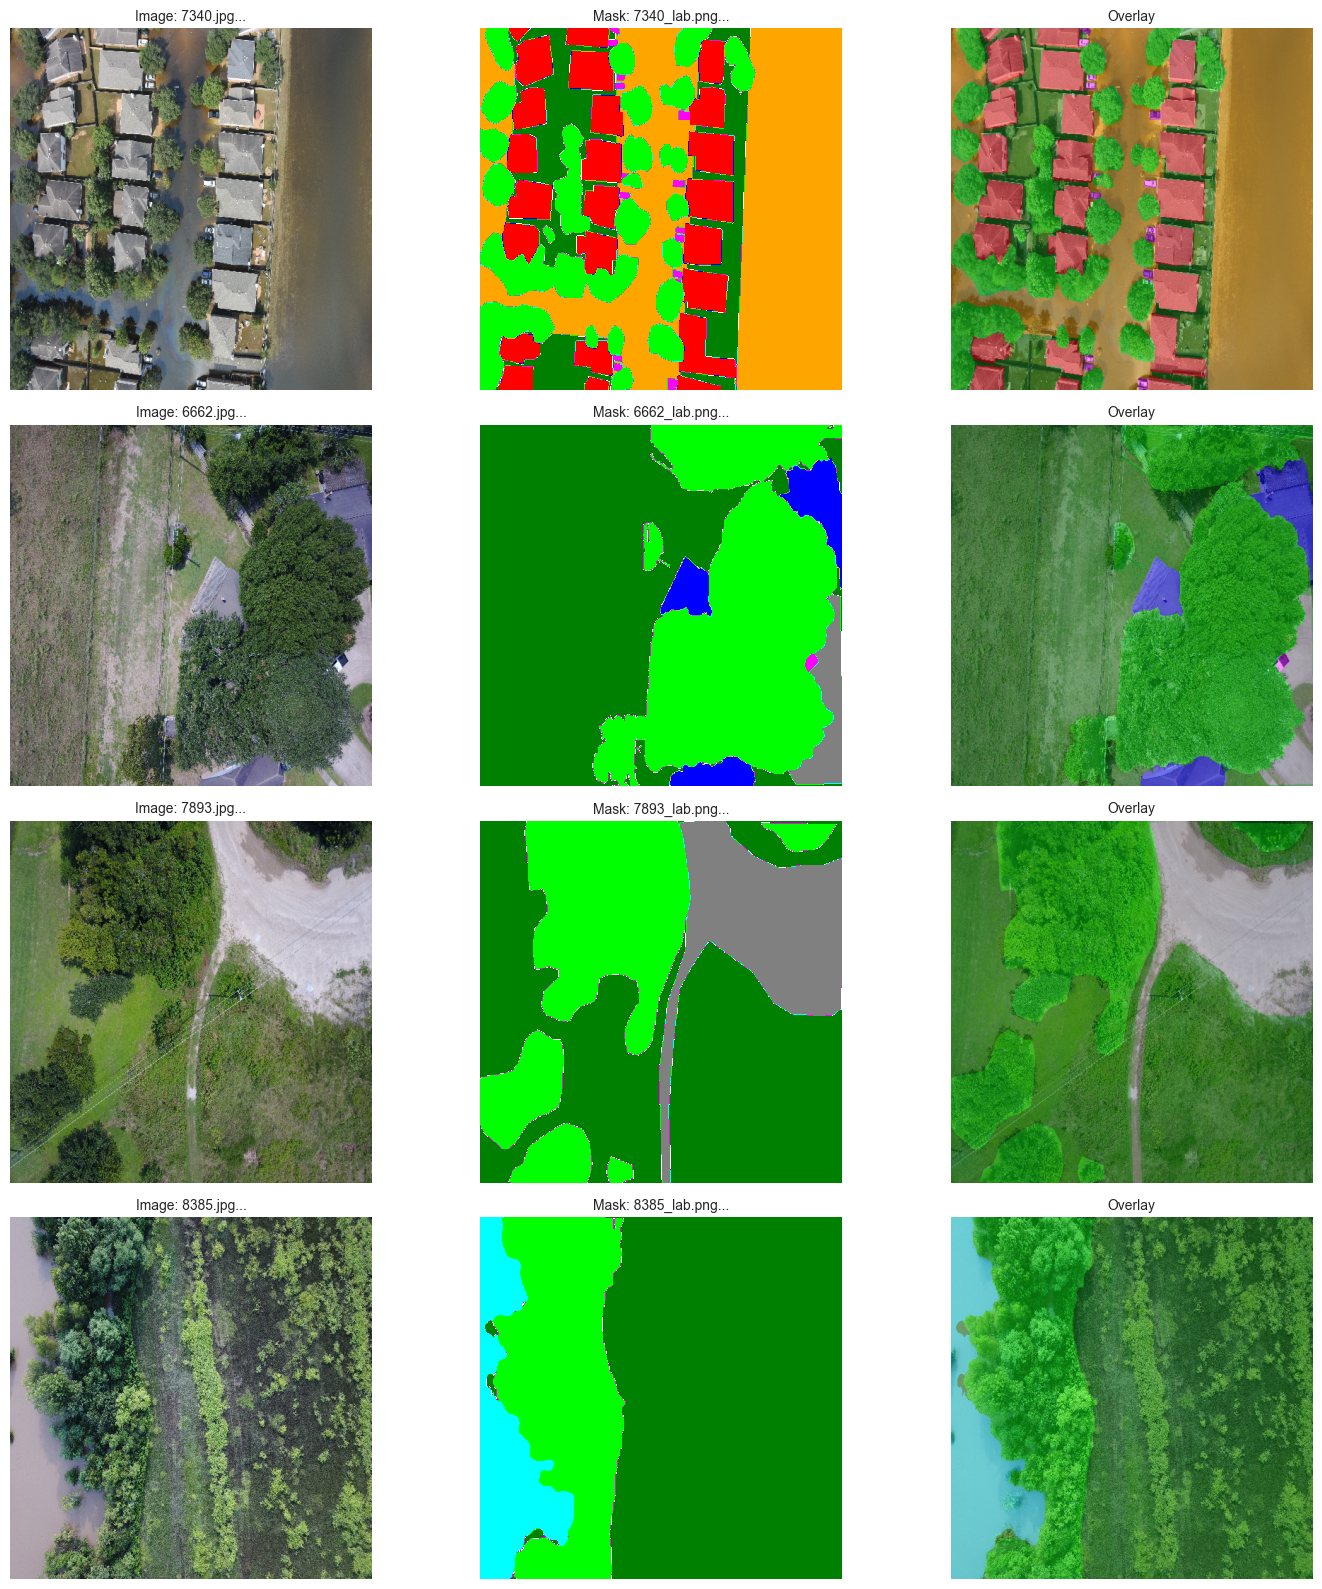

In [7]:
# ============================================================
# 5. Visualize Sample Images
# ------------------------------------------------------------
# Show random image ↔ mask pairs: [Image | Mask | Overlay]
# Uses official FloodNet mask naming convention: {stem}_lab.png
# ============================================================

import matplotlib.colors as mcolors

# Normalize class colors to [0,1] for matplotlib
CLASS_COLORS_NORMALIZED = {
    i: tuple(c / 255 for c in Config.CLASS_COLORS[i]) 
    for i in range(Config.NUM_CLASSES)
}
colors_list = [CLASS_COLORS_NORMALIZED[i] for i in range(Config.NUM_CLASSES)]
custom_cmap = mcolors.ListedColormap(colors_list)


def find_matching_mask(image_path, mask_dir):
    """
    Return mask path using official FloodNet pattern: {stem}_lab.png.
    Logs a warning if mask is missing.
    """
    stem = image_path.stem
    mask_path = mask_dir / f"{stem}_lab.png"
    if mask_path.exists():
        return mask_path
    print(f"Warning: Mask not found: {mask_path}")
    return None


def visualize_samples(image_dir, mask_dir, num_samples=4, save_path=None):
    """
    Visualize random samples (image, colored mask, overlay).
    - image_dir: Path to RGB images
    - mask_dir:  Path to single-channel masks
    """
    image_files = sorted(list(image_dir.glob("*")))
    if not image_files:
        print("❌ No images found!")
        return

    # choose random indices without replacement
    indices = np.random.choice(len(image_files), min(num_samples, len(image_files)), replace=False)

    fig, axes = plt.subplots(num_samples, 3, figsize=(15, 4 * num_samples))
    if num_samples == 1:
        axes = axes.reshape(1, -1)

    for i, idx in enumerate(indices):
        img_path = image_files[idx]
        mask_path = find_matching_mask(img_path, mask_dir)

        # Load and resize image (BGR -> RGB)
        img = cv2.imread(str(img_path))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (512, 512))

        # Column 1: original image
        axes[i, 0].imshow(img)
        axes[i, 0].set_title(f"Image: {img_path.name[:25]}...", fontsize=10)
        axes[i, 0].axis("off")

        # Columns 2 & 3: mask and overlay (if available)
        if mask_path and mask_path.exists():
            mask = cv2.imread(str(mask_path), cv2.IMREAD_GRAYSCALE)
            mask = cv2.resize(mask, (512, 512), interpolation=cv2.INTER_NEAREST)

            # Display mask with consistent colormap
            axes[i, 1].imshow(mask, cmap=custom_cmap, vmin=0, vmax=Config.NUM_CLASSES - 1)
            axes[i, 1].set_title(f"Mask: {mask_path.name[:25]}...", fontsize=10)
            axes[i, 1].axis("off")

            # Build RGB colored mask for overlay
            colored_mask = np.zeros((512, 512, 3), dtype=np.uint8)
            for cls_id, color in Config.CLASS_COLORS.items():
                colored_mask[mask == cls_id] = color

            overlay = cv2.addWeighted(img, 0.6, colored_mask, 0.4, 0)
            axes[i, 2].imshow(overlay)
            axes[i, 2].set_title("Overlay", fontsize=10)
            axes[i, 2].axis("off")
        else:
            # Informative placeholder when mask missing
            axes[i, 1].text(0.5, 0.5, "Mask not found", ha="center", va="center", fontsize=12)
            axes[i, 1].axis("off")
            axes[i, 2].axis("off")

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches="tight")
        print(f"💾 Saved visualization to: {save_path}")

    plt.show()


# -------------------------
# Run sample visualization
# -------------------------
print("\n" + "=" * 60)
print("🎨 SAMPLE VISUALIZATIONS")
print("=" * 60)

visualize_samples(
    Config.TRAIN_IMAGES,
    Config.TRAIN_MASKS,
    num_samples=4,
    save_path=Config.VIZ_DIR / "sample_train_images.png"
)


In [10]:
# ============================================================
# 6. Class Distribution Analysis
# ------------------------------------------------------------
# Compute pixel-wise frequency of each class across mask files,
# summarize results in a DataFrame, and save to CSV.
# ============================================================

def analyze_class_distribution(mask_dir, num_samples=None):
    """
    Compute pixel counts per class from mask images.

    Args:
        mask_dir (Path): directory containing mask files.
        num_samples (int|None): limit number of masks to process (useful for quick checks).

    Returns:
        (Counter, int): (class_pixels_counter, total_pixel_count)
    """
    mask_files = sorted(list(mask_dir.glob("*")))
    if num_samples:
        mask_files = mask_files[:num_samples]

    class_pixels = Counter()  # accumulate pixel counts per class id
    total_pixels = 0

    print(f"\n📊 Analyzing class distribution in {len(mask_files)} masks...")

    for mask_path in tqdm(mask_files, desc="Processing masks"):
        # Load mask as single-channel array where pixel values are class ids
        mask = cv2.imread(str(mask_path), cv2.IMREAD_GRAYSCALE)
        if mask is not None:
            unique, counts = np.unique(mask, return_counts=True)
            for cls, count in zip(unique, counts):
                class_pixels[int(cls)] += int(count)
                total_pixels += int(count)

    return class_pixels, total_pixels


# -------------------------
# Run analysis (training masks)
# -------------------------
print("\n" + "=" * 60)
print("📈 CLASS DISTRIBUTION ANALYSIS")
print("=" * 60)

# Analyze entire training mask set (omit num_samples for full run)
class_pixels, total_pixels = analyze_class_distribution(Config.TRAIN_MASKS)

# -------------------------
# Build DataFrame for reporting
# -------------------------
distribution_data = []
for cls_id in range(Config.NUM_CLASSES):
    count = class_pixels.get(cls_id, 0)
    percentage = (count / total_pixels) * 100 if total_pixels > 0 else 0.0
    distribution_data.append({
        "Class ID": int(cls_id),
        "Class Name": Config.CLASS_NAMES[cls_id],
        "Pixel Count": int(count),
        "Percentage": float(percentage)
    })

df_distribution = pd.DataFrame(distribution_data)

# Print a tidy table to console
print("\n" + df_distribution.to_string(index=False))

# -------------------------
# Save results to CSV
# -------------------------
csv_path = Config.METRICS_DIR / "class_distribution.csv"
csv_path.parent.mkdir(parents=True, exist_ok=True)  # ensure directory exists
df_distribution.to_csv(csv_path, index=False)
print(f"\n💾 Saved distribution to: {csv_path}")



📈 CLASS DISTRIBUTION ANALYSIS

📊 Analyzing class distribution in 1445 masks...


Processing masks: 100%|██████████| 1445/1445 [02:41<00:00,  8.94it/s]


 Class ID           Class Name  Pixel Count  Percentage
        0           Background    308842999    1.735352
        1     Building-flooded    318505750    1.789646
        2 Building-non-flooded    572544673    3.217060
        3         Road-flooded    559209008    3.142129
        4     Road-non-flooded    966381628    5.429984
        5                Water   1979142780   11.120568
        6                 Tree   3107988573   17.463418
        7              Vehicle     32624508    0.183313
        8                 Pool     36997059    0.207882
        9                Grass   9914900430   55.710647

💾 Saved distribution to: D:\Projects\Image_Segmentation_for_Disaster_Resilience\Disaster-segmentation\results\metrics\class_distribution.csv


💾 Saved distribution plot to: D:\Projects\Image_Segmentation_for_Disaster_Resilience\Disaster-segmentation\results\visualizations\data_exploration\class_distribution.png


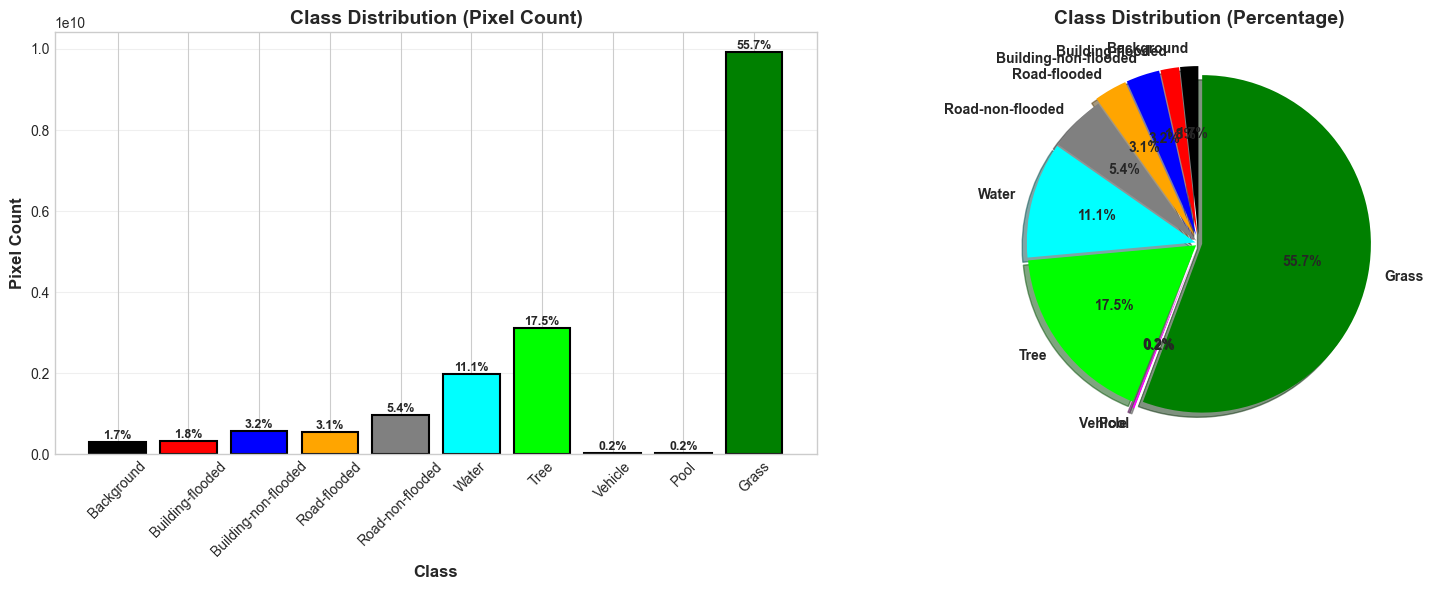

In [11]:
# ============================================================
# 7. Visualize Class Distribution
# ------------------------------------------------------------
# Plot the distribution of pixel counts per class using:
#   • Bar chart (absolute counts + percentages as labels)
#   • Pie chart (percentage composition)
# ============================================================

def plot_class_distribution(df, save_path=None):
    """Visualize class distribution using bar and pie charts."""
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Normalized RGB colors for plotting
    colors = [np.array(Config.CLASS_COLORS[i]) / 255 
              for i in range(Config.NUM_CLASSES)]

    # -------------------------
    # Bar Chart (Pixel Count)
    # -------------------------
    bars = axes[0].bar(
        df["Class Name"],
        df["Pixel Count"],
        color=colors,
        edgecolor="black",
        linewidth=1.5
    )

    axes[0].set_xlabel("Class", fontsize=12, fontweight="bold")
    axes[0].set_ylabel("Pixel Count", fontsize=12, fontweight="bold")
    axes[0].set_title("Class Distribution (Pixel Count)", fontsize=14, fontweight="bold")
    axes[0].tick_params(axis="x", rotation=45, labelsize=10)
    axes[0].grid(axis="y", alpha=0.3)

    # Add percentage labels above bars
    for bar, pct in zip(bars, df["Percentage"]):
        height = bar.get_height()
        axes[0].text(
            bar.get_x() + bar.get_width() / 2,
            height,
            f"{pct:.1f}%",
            ha="center",
            va="bottom",
            fontsize=9,
            fontweight="bold"
        )

    # -------------------------
    # Pie Chart (Percentages)
    # -------------------------
    # Slightly increase explode for rare classes (<5%)
    explode = [0.05 if pct < 5 else 0.02 for pct in df["Percentage"]]

    axes[1].pie(
        df["Percentage"],
        labels=df["Class Name"],
        autopct="%1.1f%%",
        colors=colors,
        explode=explode,
        shadow=True,
        startangle=90,
        textprops={"fontsize": 10, "fontweight": "bold"}
    )

    axes[1].set_title("Class Distribution (Percentage)", fontsize=14, fontweight="bold")

    plt.tight_layout()

    # Save plot if a path is provided
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches="tight")
        print(f"💾 Saved distribution plot to: {save_path}")

    plt.show()


# -------------------------
# Generate distribution visualization
# -------------------------
plot_class_distribution(
    df_distribution,
    save_path=Config.VIZ_DIR / "class_distribution.png"
)


In [12]:
# ============================================================
# 8. Calculate Class Weights
# ------------------------------------------------------------
# Compute per-class weights to mitigate label imbalance.
# Supports:
#  - 'balanced' : inverse-frequency (with optional power scaling)
#  - 'effective': effective-number-of-samples (for extreme imbalance)
# Results are normalized and clipped to avoid extremes.
# ============================================================

def calculate_class_weights(class_pixels, total_pixels, method='balanced', power=0.5):
    """
    Compute normalized class weights.

    Args:
        class_pixels (dict): pixel counts per class (int keys).
        total_pixels (int): total pixel count across masks.
        method (str): 'balanced' or 'effective'.
        power (float): exponent for balanced method (0.5 -> milder scaling).

    Returns:
        dict: {class_id: normalized_weight}
    """
    weights = {}
    num_classes = Config.NUM_CLASSES

    if method == 'balanced':
        # Inverse frequency with power adjustment to reduce aggressiveness
        for cls in range(num_classes):
            count = max(1, class_pixels.get(cls, 0))  # avoid div-by-zero
            weights[cls] = (total_pixels / (num_classes * count)) ** power

    elif method == 'effective':
        # Effective number of samples (CVPR 2019 style)
        beta = 0.9999
        for cls in range(num_classes):
            count = max(1, class_pixels.get(cls, 0))
            effective_num = 1.0 - np.power(beta, count)
            # small epsilon guard
            weights[cls] = (1.0 - beta) / (effective_num + 1e-12)

    else:
        raise ValueError(f"Unknown method: {method}")

    # Normalize to [0, 1] (max -> 1.0)
    max_weight = max(weights.values())
    weights = {k: v / max_weight for k, v in weights.items()}

    # Clip to avoid extreme influence during training
    weights = {k: float(max(0.1, min(v, 10.0))) for k, v in weights.items()}

    return weights


# -------------------------
# Compute & persist weights
# -------------------------
print("\n" + "=" * 60)
print("⚖️  CLASS WEIGHTS CALCULATION")
print("=" * 60)

balanced_weights = calculate_class_weights(class_pixels, total_pixels, method='balanced', power=0.5)
effective_weights = calculate_class_weights(class_pixels, total_pixels, method='effective')

print("\n📊 Balanced Weights (power=0.5, recommended):")
for cls in range(Config.NUM_CLASSES):
    print(f"  Class {cls} ({Config.CLASS_NAMES[cls]:25s}): {balanced_weights[cls]:.4f}")

print("\n📊 Effective Number Weights:")
for cls in range(Config.NUM_CLASSES):
    print(f"  Class {cls} ({Config.CLASS_NAMES[cls]:25s}): {effective_weights[cls]:.4f}")

# Save weights and distribution
weights_data = {
    "class_distribution": {str(k): int(v) for k, v in class_pixels.items()},
    "balanced_weights": balanced_weights,
    "effective_weights": effective_weights
}

weights_path = Config.METRICS_DIR / "class_weights.json"
weights_path.parent.mkdir(parents=True, exist_ok=True)
with open(weights_path, 'w') as f:
    json.dump(weights_data, f, indent=2)

print(f"\n💾 Saved class weights to: {weights_path}")



⚖️  CLASS WEIGHTS CALCULATION

📊 Balanced Weights (power=0.5, recommended):
  Class 0 (Background               ): 0.3250
  Class 1 (Building-flooded         ): 0.3200
  Class 2 (Building-non-flooded     ): 0.2387
  Class 3 (Road-flooded             ): 0.2415
  Class 4 (Road-non-flooded         ): 0.1837
  Class 5 (Water                    ): 0.1284
  Class 6 (Tree                     ): 0.1025
  Class 7 (Vehicle                  ): 1.0000
  Class 8 (Pool                     ): 0.9390
  Class 9 (Grass                    ): 0.1000

📊 Effective Number Weights:
  Class 0 (Background               ): 1.0000
  Class 1 (Building-flooded         ): 1.0000
  Class 2 (Building-non-flooded     ): 1.0000
  Class 3 (Road-flooded             ): 1.0000
  Class 4 (Road-non-flooded         ): 1.0000
  Class 5 (Water                    ): 1.0000
  Class 6 (Tree                     ): 1.0000
  Class 7 (Vehicle                  ): 1.0000
  Class 8 (Pool                     ): 1.0000
  Class 9 (Grass    

----------------------------------------
Generating Class Legend...
----------------------------------------
💾 Legend graphic generated: D:\Projects\Image_Segmentation_for_Disaster_Resilience\Disaster-segmentation\results\visualizations\data_exploration\class_legend.png


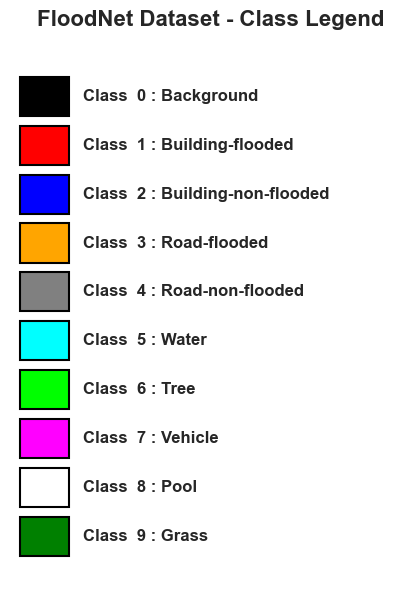

In [14]:
# ============================================================
# 9. Create Class Legend
# ------------------------------------------------------------
# Render a compact visual legend mapping class IDs → names → colors.
# Useful for quick manual verification that mask colors align with
# the documented class names.
# ============================================================

def create_class_legend(save_path=None):
    """
    Generate and optionally save a class legend image.

    Args:
        save_path (Path | str | None): If provided, legend is saved to this path.
    """
    # Figure setup: wide enough to list classes comfortably
    fig, ax = plt.subplots(figsize=(10, 6))

    # Draw one colored rectangle + label per class
    # We draw from top → bottom for better visual ordering.
    for i, cls_name in enumerate(Config.CLASS_NAMES):
        cls_id = i

        # Convert RGB 0-255 to matplotlib-friendly 0-1 range
        color = np.array(Config.CLASS_COLORS[cls_id]) / 255.0

        # Place rectangles so the first class appears at the top
        y = Config.NUM_CLASSES - i - 1
        rect = plt.Rectangle((0, y), 1, 0.8, color=color, ec='black', linewidth=1.5)
        ax.add_patch(rect)

        # Label on the right of the colored patch
        ax.text(
            1.3, y + 0.4,
            f"Class {cls_id:2d} : {cls_name}",
            va='center',
            fontsize=12,
            fontweight='bold'
        )

    # Layout adjustments: bounds, aspect ratio, hide axes
    ax.set_xlim(-0.2, 8)
    ax.set_ylim(-0.5, Config.NUM_CLASSES + 0.5)
    ax.set_aspect('equal')
    ax.axis('off')

    # Title and tight layout to avoid clipping
    ax.set_title("FloodNet Dataset - Class Legend", fontsize=16, fontweight='bold', pad=12)
    plt.tight_layout()

    # Save file if path provided
    if save_path:
        save_path = Path(save_path)
        save_path.parent.mkdir(parents=True, exist_ok=True)
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"💾 Legend graphic generated: {save_path}")

    plt.show()


# -------------------------
# Execute and save legend
# -------------------------
print("-" * 40)
print("Generating Class Legend...")
print("-" * 40)

create_class_legend(save_path=Config.VIZ_DIR / "class_legend.png")


In [15]:
# ============================================================
# 10. Summary Report (Windows-safe)
# ------------------------------------------------------------
# Generate a human-readable summary of the exploration step,
# save it as a UTF-8 text file (Windows-safe), and print to console.
# ============================================================

# Header
print("\n" + "═" * 70)
print("DATASET EXPLORATION SUMMARY")
print("═" * 70)

# Build a multiline summary string with key statistics and paths.
# Using f-string ensures values are interpolated and easy to read.
summary = f"""
Dataset Statistics:
{'─' * 70}
  Training Set      : {dataset_stats['Train Images']['count']:5d} images
  Validation Set    : {dataset_stats['Val Images']['count']:5d} images
  Test Set          : {dataset_stats['Test Images']['count']:5d} images
  Total             : {sum(dataset_stats[k]['count'] for k in ['Train Images', 'Val Images', 'Test Images']):5d} images

Image Properties:
{'─' * 70}
  Original Size     : Varies (mostly ~4000×3000)
  Target Size       : {Config.IMG_HEIGHT}×{Config.IMG_WIDTH}
  Channels          : RGB (3)
  Avg File Size     : {np.mean(props['file_sizes']):.1f} KB

Class Distribution Highlights:
{'─' * 70}
  Most Common       : {df_distribution.loc[df_distribution['Percentage'].idxmax(), 'Class Name']} ({df_distribution['Percentage'].max():.2f}%)
  Least Common      : {df_distribution.loc[df_distribution['Percentage'].idxmin(), 'Class Name']} ({df_distribution['Percentage'].min():.3f}%)
  Severe imbalance detected → Use class weights!

Output Files Generated:
{'─' * 70}
  - Sample images      → {Config.VIZ_DIR / "sample_train_images.png"}
  - Distribution plot  → {Config.VIZ_DIR / "class_distribution.png"}
  - Class legend       → {Config.VIZ_DIR / "class_legend.png"}
  - CSV stats          → {Config.METRICS_DIR / "class_distribution.csv"}
  - Class weights      → {Config.METRICS_DIR / "class_weights.json"}

NEXT → Run notebook 02_preprocessing.ipynb
{'═' * 70}
"""

# Print summary to console for immediate inspection
print(summary)

# Save the report to disk using explicit UTF-8 encoding (Windows-safe).
report_path = Config.RESULTS_DIR / "reports" / "data_exploration_report.txt"
report_path.parent.mkdir(parents=True, exist_ok=True)  # ensure directory exists

with open(report_path, 'w', encoding='utf-8') as f:
    f.write(summary)

# Final status messages
print(f"Summary report saved → {report_path}")
print("DATA EXPLORATION SUCCESSFULLY COMPLETED!")


══════════════════════════════════════════════════════════════════════
DATASET EXPLORATION SUMMARY
══════════════════════════════════════════════════════════════════════

Dataset Statistics:
──────────────────────────────────────────────────────────────────────
  Training Set      :  1445 images
  Validation Set    :   450 images
  Test Set          :   448 images
  Total             :  2343 images

Image Properties:
──────────────────────────────────────────────────────────────────────
  Original Size     : Varies (mostly ~4000×3000)
  Target Size       : 256×256
  Channels          : RGB (3)
  Avg File Size     : 5617.9 KB

Class Distribution Highlights:
──────────────────────────────────────────────────────────────────────
  Most Common       : Grass (55.71%)
  Least Common      : Vehicle (0.183%)
  Severe imbalance detected → Use class weights!

Output Files Generated:
──────────────────────────────────────────────────────────────────────
  - Sample images      → D:\Projects\Image